# Rotten Tomatoes movie review - Weekly Project

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis

This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: 
- negative
- somewhat negative
- neutral
- somewhat positive
- positive. 

Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

In [253]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
import unicodedata


In [254]:
from bs4 import BeautifulSoup

from collections import Counter
from matplotlib import pyplot
from numpy import where

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [255]:
df = pd.read_csv('train.csv')

In [256]:
df.head(10)

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,122,4,positively,3
1,1,19366,851,disguise the slack complacency of -LRB- Godard...,1
2,2,54763,2726,realizes a fullness that does not negate the s...,3
3,3,89708,4667,sealed,2
4,4,33494,1571,Go Where We Went 8 Movies Ago,3
5,5,146330,7957,the thin soup,2
6,6,62064,3138,keeps the energy humming,3
7,7,123644,6640,the most poorly staged and lit action in memory,0
8,8,89875,4677,a $ 40 million version,2
9,9,80766,4162,"putting together familiar themes of family , f...",3


In [257]:
#drop duplicate
df = df.drop_duplicates()

#check null data
df.isnull().sum()

Unnamed: 0    0
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [258]:
df['word_count'] = df['Phrase'].str.split(' ').str.len()

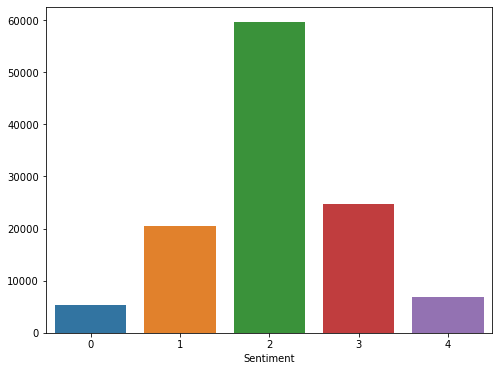

In [259]:
#check unique sentiment label
df['Sentiment'].unique()

#array([3, 1, 2, 0, 4], dtype=int64)
#0 - most negative
#1 - somewhat negative
#2 - neutral
#3 - somewhat postive
#4 - most positive

#check distribution of sentiment
dist = df.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(dist.keys(), dist.values);

In [260]:
#use this to determine class for each sentiment
#since neutral tone is the most occured one, use it as the nominator i.e. Wi = ni / n2

weight = {0: dist[2]/dist[0],
         1: dist[2]/dist[1],
         2: dist[2]/dist[2],
         3: dist[2]/dist[3],
         4: dist[2]/dist[4]}
weight

{0: 11.346849419379403,
 1: 2.8986529202937317,
 2: 1.0,
 3: 2.405561385099685,
 4: 8.706543967280163}

In [261]:
#dictionary for stop words
stop_words = stopwords.words('english')

#dictionary of lematising words
lemmatizer = WordNetLemmatizer()

#dictionary of stemming words
porter = PorterStemmer()

In [262]:
#Preprocessing words
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = BeautifulSoup(text, "lxml").text
    
    # Remove non-ASCII characters 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #get only letters
    text = re.sub("[^a-zA-Z]"," ",text)
    
    #lower case and split
    text = text.lower().split()
    
    #remove stop words
#     stops = set(stopwords.words("english")) #faster to search through a set than a list
#     text = [ w for w in text if not w in stop_words]  
    
    #lemmatising
    text = [lemmatizer.lemmatize(w) for w in text]
    
    #steming words
    text = [porter.stem(w) for w in text]        
    
    #join words
    text = " ".join(text)
    return text

preprocessor("Hi there, I am loving  this, like with 234a& lot of love. He loves it too@~@>: @A:>S")
preprocessor("This is not bad at all 079 ^$>>")

'thi is not bad at all'

In [263]:
#determine X and y accordingly 
#X = df['Phrase']
#y = df['Sentiment']

X = df['Phrase']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

In [264]:
#vertorise data with features

#tfidf reduce the emphasis of the frequency of occurence of the words
#which is more suitable for a categories training, such as detecting what kinds of news the text is
tfidf = TfidfVectorizer(input='content', 
                        encoding='utf-8', 
                        decode_error='strict', 
                        strip_accents=None, 
                        lowercase=True, 
                        preprocessor=preprocessor, 
                        tokenizer=word_tokenize, 
                        analyzer='word', 
                        stop_words=None, 
                        token_pattern='(?u)\b\w\w+\b', 
                        ngram_range=(1, 2), 
                        max_df=1.0, 
                        min_df=1, 
                        max_features=None, 
                        vocabulary=None, 
                        binary=True, 
                        dtype=np.float64, 
                        norm='l2', 
                        use_idf=True, 
                        smooth_idf=True, 
                        sublinear_tf=False)

#countvectorizer emphasises on the frequency of occurence of the words
#which is more suitable for a sentimental training
count = CountVectorizer(input='content', 
                                   encoding='utf-8', 
                                   decode_error='strict', 
                                   strip_accents=None, 
                                   lowercase=True, 
                                   preprocessor=preprocessor, 
                                   tokenizer=word_tokenize, 
                                   stop_words=None, 
                                   token_pattern='(?u)\b\w\w+\b', 
                                   ngram_range=(1, 2), 
                                   analyzer='word', 
                                   max_df=1.0, 
                                   min_df=1, 
                                   max_features=None, 
                                   vocabulary=None, 
                                   binary=True, 
                                   dtype=np.float64)

logistic_regression = LogisticRegression(penalty='l2', 
                                         dual=False, 
                                         tol=0.000001, 
                                         C=1.0, 
                                         fit_intercept=True, 
                                         intercept_scaling=1, 
                                         class_weight=None,#weight, 
                                         random_state=102, 
                                         solver='lbfgs', 
                                         max_iter=1000000, 
                                         multi_class='multinomial', 
                                         verbose=0, 
                                         warm_start=True, 
                                         n_jobs=None, 
                                         l1_ratio=None)

# A pipeline is what chains several steps together, once the initial exploration is done. 
# For example, some codes are meant to transform features — normalise numericals, or turn text into vectors, 
# or fill up missing data, they are transformers; other codes are meant to predict variables by fitting an algorithm,
# they are estimators. Pipeline chains all these together which can then be applied to training data
clf = Pipeline([('vect', count),
                ('clf', LogisticRegression())])

In [265]:
clf.fit(X_train, y_train)

C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\chila\miniconda3\envs\cs_ftmle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, dtype=<class 'numpy.float64'>,
                                 ngram_range=(1, 2),
                                 preprocessor=<function preprocessor at 0x000001E926338048>,
                                 token_pattern='(?u)\x08\\w\\w+\x08',
                                 tokenizer=<function word_tokenize at 0x000001E9602DD8B8>)),
                ('clf', LogisticRegression())])

In [267]:
#Test prediction
predictions = clf.predict(X_test)

In [268]:
#Evaluate
print('accuracy:',accuracy_score(y_test,predictions))
print('confusion matrix:\n',confusion_matrix(y_test,predictions))
print('classification report:\n',classification_report(y_test,predictions))

# WITHOUT STOP WORDS, TfidfVectorizer with ngrams = 2
# accuracy: 0.6451364859669358
# confusion matrix:
#  [[  175   524   291    19     0]
#  [  126  1567  2295    91     7]
#  [   22   612 10638   667    26]
#  [    2    70  2359  2387   164]
#  [    0     9   218   805   335]]
# classification report:
#                precision    recall  f1-score   support

#            0       0.54      0.17      0.26      1009
#            1       0.56      0.38      0.46      4086
#            2       0.67      0.89      0.77     11965
#            3       0.60      0.48      0.53      4982
#            4       0.63      0.25      0.35      1367

#     accuracy                           0.65     23409
#    macro avg       0.60      0.43      0.47     23409
# weighted avg       0.63      0.65      0.62     23409

accuracy: 0.66000256311675
confusion matrix:
 [[  342   477   177    12     1]
 [  341  1788  1844   100    13]
 [   65   792 10187   879    42]
 [    8    81  1937  2592   364]
 [    1     6   121   698   541]]
classification report:
               precision    recall  f1-score   support

           0       0.45      0.34      0.39      1009
           1       0.57      0.44      0.49      4086
           2       0.71      0.85      0.78     11965
           3       0.61      0.52      0.56      4982
           4       0.56      0.40      0.46      1367

    accuracy                           0.66     23409
   macro avg       0.58      0.51      0.54     23409
weighted avg       0.65      0.66      0.65     23409



Text(0.5, 15.0, 'Predicted label')

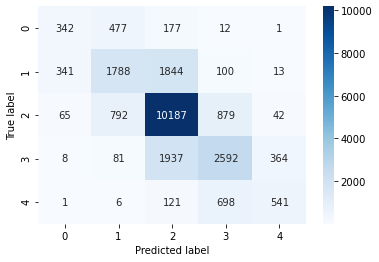

In [269]:
cm = confusion_matrix(y_test, predictions)
# view with a heatmap
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', xticklabels=['0', '1','2','3','4'], yticklabels=['0', '1','2','3','4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [271]:
#dump into an pickle file to read and run later
pickle.dump(clf, open('review_logistic_regression_count_ngram12.pkl', 'wb'))

In [127]:
#read pickle file model
with open('review_logistic_regression.pkl', 'rb') as model:
    reload_model = pickle.load(model)
    

In [128]:
#read test.csv file and make prediction
df_test_unlabel = pd.read_csv('test.csv')
X_test_unlabel = df_test_unlabel['Phrase']

preds = reload_model.predict(X_test_unlabel)


In [102]:
#save to submission.csv file
df_test_unlabel['Sentiment'] = preds
df_test_unlabel.to_csv('./submission.csv', index=False)